# Лабораторная работа 2
### Выполнила: Иванова Анастасия Денисовна

Для восстановления итоговой модели надо следовать по ячейкам, на которых по порядку написаны шаги. Именно такой порядок выполнения дает итоговый результат. Шаги введены, потому что структура, по которой я делала анализ, не позволяет соблюсти этот порядок.

In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import torch.nn as nn
import torch
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [6]:
# шаг 1

# загружаем датасет train & test
df_train = pd.read_csv("DOTA2_TRAIN_features.csv")
df_test = pd.read_csv("DOTA2_TEST_features.csv")
df_train_targets = pd.read_csv("DOTA2_TRAIN_targets.csv")

# объединяем признаки объектов с таргетами
df_train = pd.merge(df_train, df_train_targets)

# фиксируем match_id для sample_submission и удаляем его, 
# т.к. очевидно, что Guid не повлияет на предсказание
match_id = df_test["match_id"]
del df_train["match_id"]
del df_test["match_id"]

# фиксируем таргет для обучения моделей
y = df_train_targets["radiant_win"]

# и удаляем его
del df_train["radiant_win"]

In [3]:
# не использую
import json

data_json = []
with open('tome_of_knowledge.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        data_json.append(json.loads(line))

: 

Пробовала загружать json-файл построчно, чтобы вытащить из него какие-то признаки. Это не получилось, т.к. ядро юпитера спустя 20 секунд умирает, а сам компьютер зависает. 

### EDA (исследовательский анализ данных)

В игре DOTA 2 есть две команды - силы света (radiant) и силы тьмы (dire) по 5 игроков в каждой. Цель игры: разрушить крепость противника и защитить свою. 

У каждого игрока есть здоровье, опыт, золото для покупки оружия, одежды и пр. Все это в совокупности влияет на исход матча.

Анализ df_train

In [66]:
df_train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,2117,22,7,15,1,5,4.0,9,15,0,...,0.133,3,1,7,0,0.405,0,0,0,0
1,3914,22,7,28,177,87,3.0,15,22,5,...,0.000,5,2,14,0,0.352,0,0,1,0
2,100000000,22,0,6,1,42,0.0,0,1,1,...,17.462,0,0,10,0,0.625,0,0,0,0
3,475,22,7,1,3,48,0.0,1,0,0,...,0.000,0,0,3,1,0.500,0,0,0,0
4,581,22,7,1,1,41,0.0,0,0,3,...,0.000,0,0,1,0,0.000,0,0,0,0


Интерпретация данных:

match_id: Уникальный идентификатор матча.

game_time: Время игры в матче.

game_mode: Режим игры. 

lobby_type: Тип лобби (например, Public matchmaking, Practice), в котором проходит игра.

objectives_len: Количество выполненных игровых задач за матч.

chat_len: Длина чата во время матча.

Для i, принадлежашего множеству {'r', 'd'}, и для j, принадлежащего множеству {'1', '2', '3', '4', '5'}

ij_hero_id: Идентификатор героя j-го игрока в команде i.

ij_kills, ij_deaths, ij_assists: Количество убийств, смертей и ассистов (помощь в убийствах) j-го игрока в команде i.

ij_denies: Количество добиваний крипов (маленькие юниты, которые бегают и с помощью который можно добывать себе золото) j-го игрока в команде i, чтобы препятствовать противнику получить опыт и золото.

ij_gold, ij_lh, ij_xp: Золото, ластхиты (убийства существ, давшие золото), опыт j-го игрока в команде i.

ij_health, ij_max_health, ij_max_mana: Здоровье, максимальное здоровье и максимальная мана (магическая сила) j-го игрока в команде i.

ij_level: Уровень j-го игрока в команде i.

ij_x, ij_y: Координаты на карте игрового персонажа j-го игрока в команде i.

ij_stuns: Общее время, на которое j-й игрок i-й команды обездвижил противников.

ij_creeps_stacked, ij_camps_stacked: Количество созданных стеков крипов и лагерей для улучшения ресурсов j-м игроком i-й команды.

ij_rune_pickups: Количество подобранных рун (усилители) j-м игроком i-й команды.

ij_firstblood_claimed: Информация о том, кто первым сделал убийство.

ij_teamfight_participation: Участие j-го игрока в команде i в командных сражениях.

ij_towers_killed: Количество уничтоженных башен j-м игроком i-й команды.

ij_roshans_killed: Количество убитых Рошанов (самый сильный нейтральный крип, из него падают плюшки) j-м игроком i-й команды.

ij_obs_placed, ij_sen_placed: Количество размещенных наблюдателей и поставленных сентри (предметы, которые раскравают невидимых персонажей) j-м игроком i-й команды.

Смотрим на статистические характеристики датафрейма

In [67]:
df_train.describe()


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,2.777200e+04,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,24995.000000,27772.000000,27772.000000,27772.000000,...,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000,27772.000000
mean,3.000534e+06,19.587354,4.780678,6.523765,7.427877,51.204523,3.135947,3.264547,4.666571,6.260046,...,11.807556,1.037232,0.341495,4.680073,0.090199,0.414851,0.298970,0.024341,1.272073,0.793857
std,1.705725e+07,6.303789,3.257337,6.507055,13.607843,34.650816,3.710659,3.300977,5.252099,8.174090,...,20.600379,3.521645,0.951968,4.642444,0.286471,0.268232,0.733285,0.170314,2.612230,2.465862
min,0.000000e+00,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-6.191000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.317500e+02,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.231000,0.000000,0.000000,0.000000,0.000000
50%,1.075000e+03,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,1.533000,0.000000,0.000000,3.000000,0.000000,0.441000,0.000000,0.000000,0.000000,0.000000
75%,1.724000e+03,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,16.048000,0.000000,0.000000,7.000000,0.000000,0.594250,0.000000,0.000000,1.000000,0.000000
max,1.000000e+08,23.000000,7.000000,41.000000,291.000000,120.000000,31.000000,27.000000,40.000000,83.000000,...,211.684000,132.000000,26.000000,52.000000,1.000000,2.000000,8.000000,5.000000,25.000000,47.000000


Для начала посмотрим на боксплоты по тем признакам, которые являются общими для всего матча.

<Figure size 1000x600 with 0 Axes>

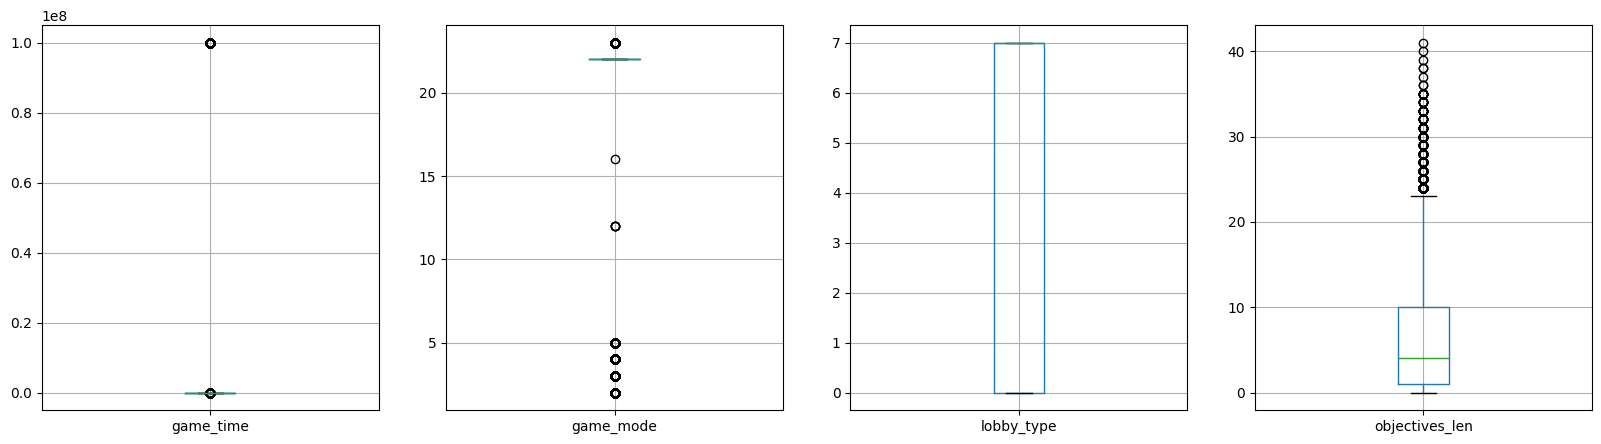

In [68]:
columns = ['game_time', 'game_mode', 'lobby_type', 'objectives_len']

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
for i, col in enumerate(columns):
    df_train[[col]].boxplot(ax=axes[i])
plt.show()

На боксплоте видно, что в game_time есть ярко выраженный выброс, но я не вижу смысла его удалять, т.к. это никак не улучшит качество итоговой модели (показали эксперименты).

Удаление остальных выбросов тоже не улучшает модель. (к тому же выбросов много)

Посмотрим на суммарные выбросы по команде radiant и dire, кроме координат героев на карте и их id.

Это будет намного удобнее, потому что признаков очень много у каждой отдельной команды.

В дальнейшем введенные на данном этапе признаки будут участвовать в обучении модели, т.к. эксперименты показали, что модель работает лучше с суммированными данными.

In [4]:
# шаг 4

r1_columns = df_train.filter(regex=r'^r1_').columns.tolist()
r2_columns = df_train.filter(regex=r'^r2_').columns.tolist()
r3_columns = df_train.filter(regex=r'^r3_').columns.tolist()
r4_columns = df_train.filter(regex=r'^r4_').columns.tolist()
r5_columns = df_train.filter(regex=r'^r5_').columns.tolist()

d1_columns = df_train.filter(regex=r'^d1_').columns.tolist()
d2_columns = df_train.filter(regex=r'^d2_').columns.tolist()
d3_columns = df_train.filter(regex=r'^d3_').columns.tolist()
d4_columns = df_train.filter(regex=r'^d4_').columns.tolist()
d5_columns = df_train.filter(regex=r'^d5_').columns.tolist()

for i, column in enumerate(r1_columns):
    if column[3:] not in ['x', 'y', 'hero_id']:
        df_train['radiant_' + column[3:]] = df_train[r1_columns[i]] + df_train[r2_columns[i]] + df_train[r3_columns[i]] + df_train[r4_columns[i]] + df_train[r5_columns[i]]
        df_test['radiant_' + column[3:]] = df_test[r1_columns[i]] + df_test[r2_columns[i]] + df_test[r3_columns[i]] + df_test[r4_columns[i]] + df_test[r5_columns[i]]

        df_train['dire_' + column[3:]] = df_train[d1_columns[i]] + df_train[d2_columns[i]] + df_train[d3_columns[i]] + df_train[d4_columns[i]] + df_train[d5_columns[i]]
        df_test['dire_' + column[3:]] = df_test[d1_columns[i]] + df_test[d2_columns[i]] + df_test[d3_columns[i]] + df_test[d4_columns[i]] + df_test[d5_columns[i]]

        del df_train[r1_columns[i]]
        del df_train[r2_columns[i]]
        del df_train[r3_columns[i]]
        del df_train[r4_columns[i]]
        del df_train[r5_columns[i]]

        del df_test[r1_columns[i]]
        del df_test[r2_columns[i]]
        del df_test[r3_columns[i]]
        del df_test[r4_columns[i]]
        del df_test[r5_columns[i]]

        del df_train[d1_columns[i]]
        del df_train[d2_columns[i]]
        del df_train[d3_columns[i]]
        del df_train[d4_columns[i]]
        del df_train[d5_columns[i]]

        del df_test[d1_columns[i]]
        del df_test[d2_columns[i]]
        del df_test[d3_columns[i]]
        del df_test[d4_columns[i]]
        del df_test[d5_columns[i]]


/tmp/ipykernel_6835/4154635234.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['radiant_' + column[3:]] = df_train[r1_columns[i]] + df_train[r2_columns[i]] + df_train[r3_columns[i]] + df_train[r4_columns[i]] + df_train[r5_columns[i]]
/tmp/ipykernel_6835/4154635234.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['radiant_' + column[3:]] = df_test[r1_columns[i]] + df_test[r2_columns[i]] + df_test[r3_columns[i]] + df_test[r4_columns[i]] + df_test[r5_columns[i]]
/tmp/ipykernel_6835/4154635234.py:20: Perfor

<Figure size 1000x600 with 0 Axes>

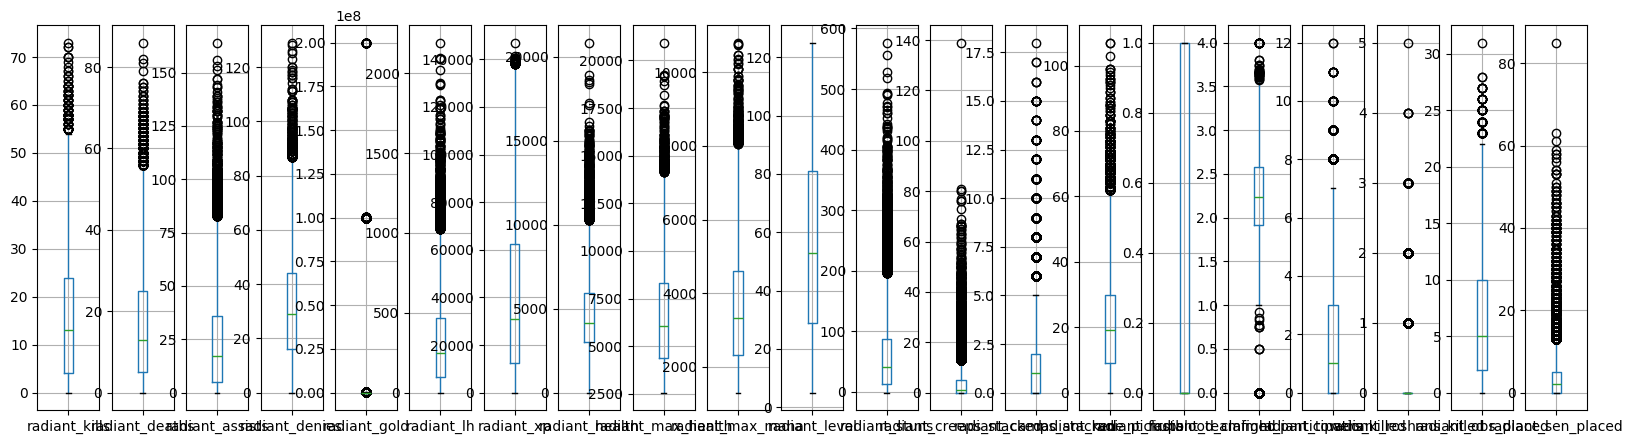

In [70]:
radiant_columns = df_train.filter(regex=r'^radiant_').columns.tolist()

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(radiant_columns), figsize=(20, 5))
for i, col in enumerate(radiant_columns):
    df_train[[col]].boxplot(ax=axes[i])
plt.show()

<Figure size 1000x600 with 0 Axes>

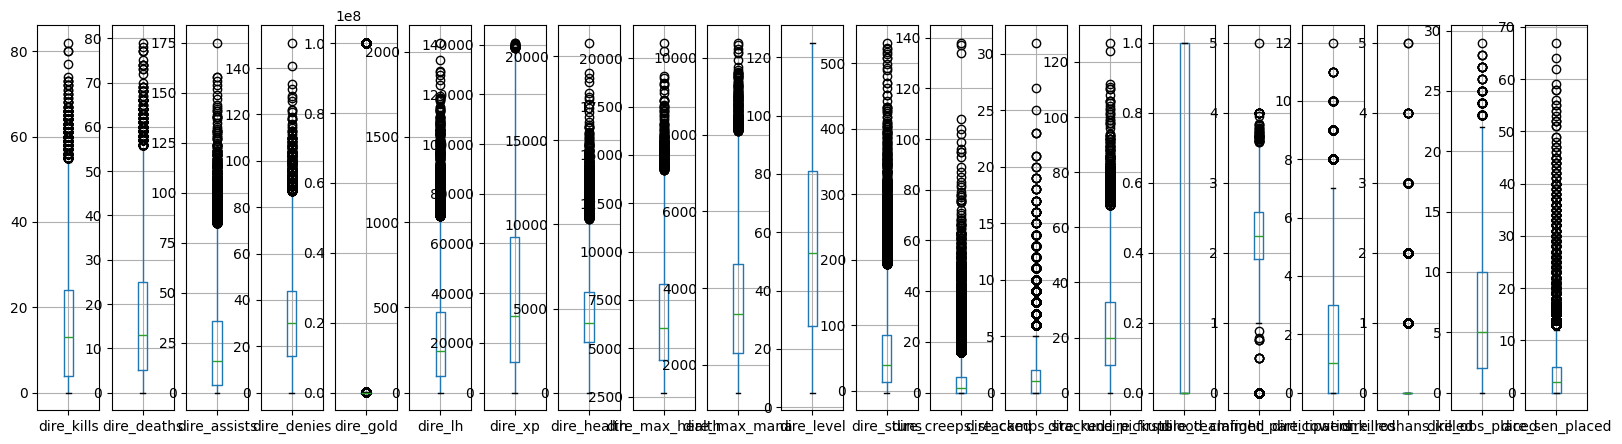

In [71]:
radiant_columns = df_train.filter(regex=r'^dire_').columns.tolist()

plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(radiant_columns), figsize=(20, 5))
for i, col in enumerate(radiant_columns):
    df_train[[col]].boxplot(ax=axes[i])
plt.show()

Выбросов очень много во многих признаках, кроме нескольких. Нет смысла их удалять, потому что мы иначе обрубим половину датасета и это только ухудшит итоговую метрику.

Посмотрим на корреляции между признаками

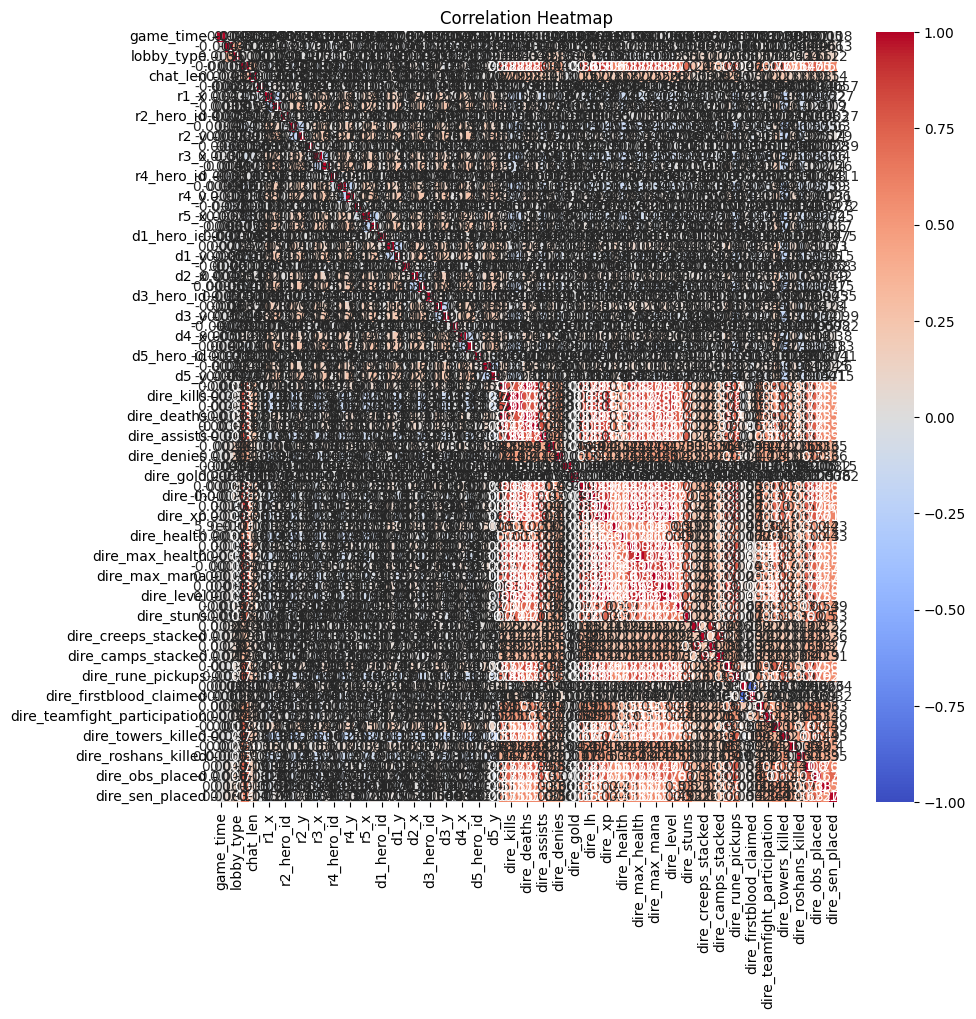

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Получилась безумная корреляционная матрица :)

Я пробовала удалять признаки, которые имеют корреляцию с таргетом не более 0.2, но это приводило к тому, что обрубалась большая часть датасета. Логистическая регрессия, SVM показывали себя довольно плохо (roc auc < 0.8), но при этом ансамбли над деревьями работали хорошо. 

Из этого можно сделать вывод, что скорее всего целевая зависимость между признаками нелинейная.

Уже сейчас понятно, что длина чата никак не влияет на исход матча.

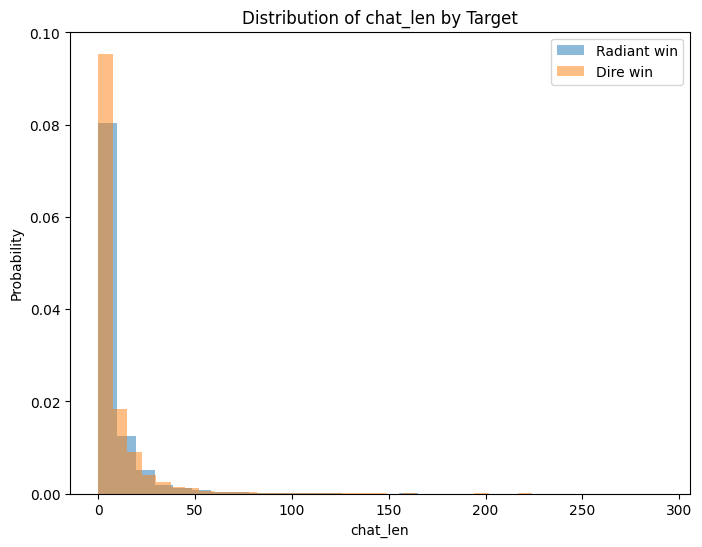

In [73]:
plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]['chat_len'], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]['chat_len'], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('chat_len')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of chat_len by Target')
plt.show()

В целом по гистограмме вероятностей видно, что при длине чата больше 50 силы у сил тьмы больше шансов на победу.
Если длина чата меньше 50, то шансы на победу приблизительно равны (при очень грубой оценке).

Таким образом, понятно, что длина чата это бесполезный признак по сравнению с другими, к тому же его отсутствие или наличие вообще никак не влияет на качетсво итоговой модели (показали эксперименты).

In [3]:
# шаг 2

# поэтому удаляю его
del df_train["chat_len"]
del df_test["chat_len"]

Так же я добавляла дополнительные признаки в виде разницы между суммарным значением этого признака у сил света и сил тьмы. Я использовала следующие признаки для этого:

towers_killed, lh, xp, gold, kills. 

Пробовала не удалять соответсвующие признаки суммарные у команд после введения разницы между ними. На кегле качество не изменяется от этого, в ноутбуке становится лучше.

Эсперименты показали, что именно такой набор признаков для разницы лучше всего влияет на качество итоговой модели.

/tmp/ipykernel_6287/429747590.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["delta_towers_killed"] = df_train["radiant_towers_killed"] - df_train["dire_towers_killed"]


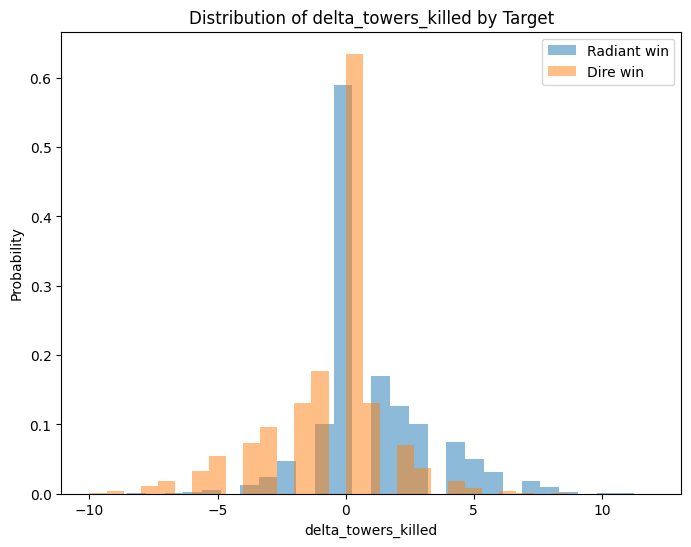

In [60]:
# шаг 5

df_train["delta_towers_killed"] = df_train["radiant_towers_killed"] - df_train["dire_towers_killed"]

plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]["delta_towers_killed"], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]["delta_towers_killed"], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('delta_towers_killed')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of delta_towers_killed by Target')
plt.show()

/tmp/ipykernel_6287/2780623858.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["delta_lh"] = df_train["radiant_lh"] - df_train["dire_lh"]


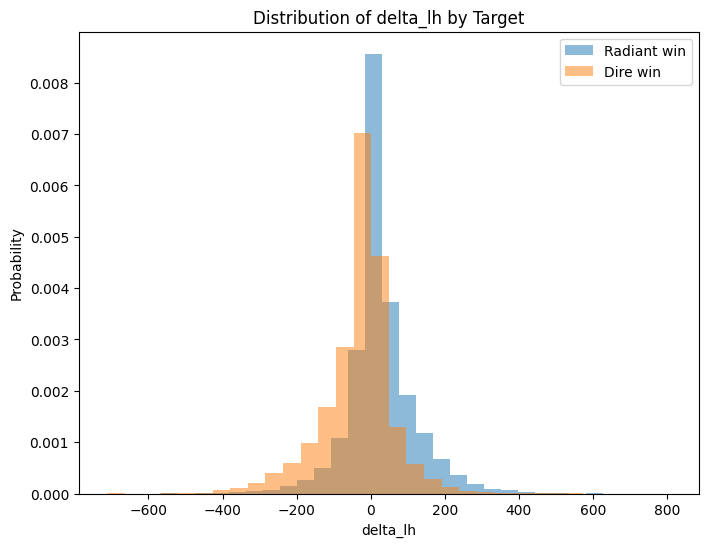

In [61]:
# шаг 6

df_train["delta_lh"] = df_train["radiant_lh"] - df_train["dire_lh"]

plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]["delta_lh"], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]["delta_lh"], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('delta_lh')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of delta_lh by Target')
plt.show()

/tmp/ipykernel_6287/2183806627.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["delta_xp"] = df_train["radiant_xp"] - df_train["dire_xp"]


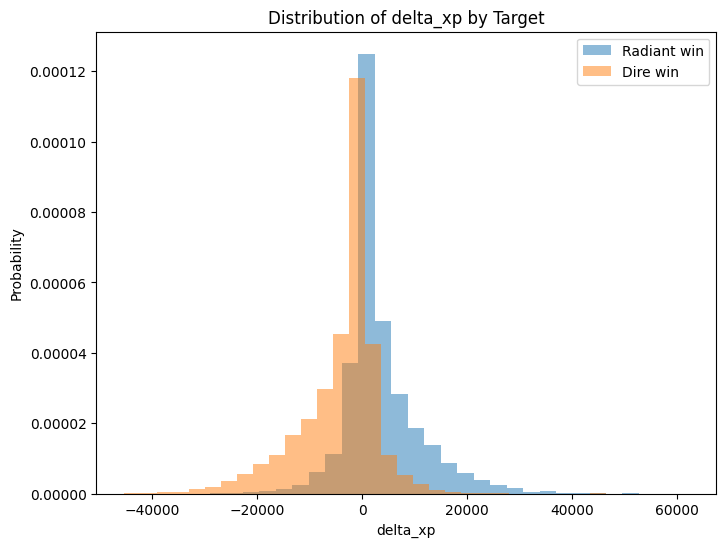

In [62]:
# шаг 7

df_train["delta_xp"] = df_train["radiant_xp"] - df_train["dire_xp"]

plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]["delta_xp"], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]["delta_xp"], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('delta_xp')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of delta_xp by Target')
plt.show()

/tmp/ipykernel_6287/4168242322.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["delta_gold"] = df_train["radiant_gold"] - df_train["dire_gold"]


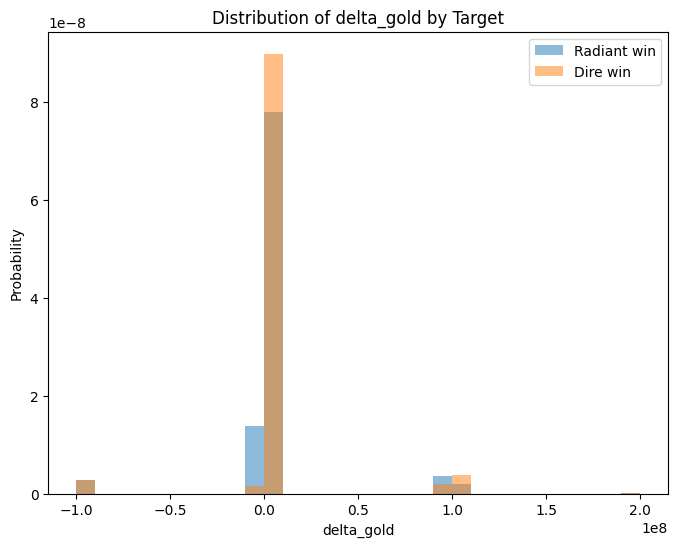

In [63]:
# шаг 8

df_train["delta_gold"] = df_train["radiant_gold"] - df_train["dire_gold"]

plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]["delta_gold"], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]["delta_gold"], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('delta_gold')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of delta_gold by Target')
plt.show()

/tmp/ipykernel_6287/3444073148.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["delta_kills"] = df_train["radiant_kills"] - df_train["dire_kills"]


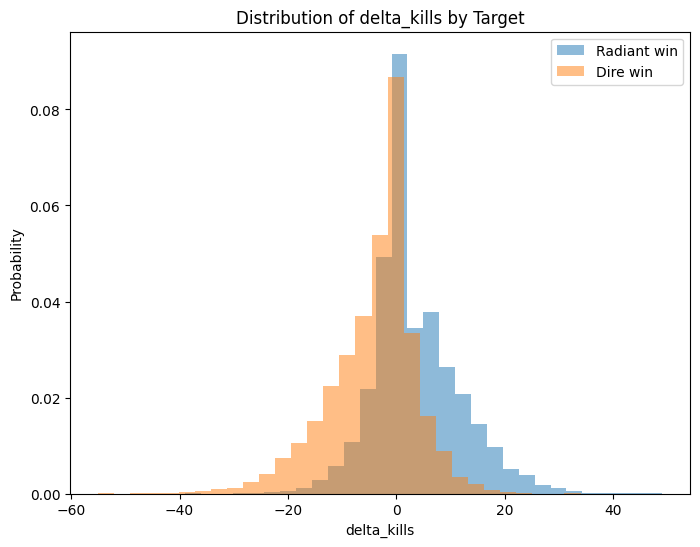

In [64]:
# шаг 9

df_train["delta_kills"] = df_train["radiant_kills"] - df_train["dire_kills"]

plt.figure(figsize=(8, 6))
plt.hist(df_train[y == 1]["delta_kills"], bins=30, alpha=0.5, label='Radiant win', density=True)
plt.hist(df_train[y == 0]["delta_kills"], bins=30, alpha=0.5, label='Dire win', density=True)
plt.xlabel('delta_kills')
plt.ylabel('Probability')
plt.legend()
plt.title('Distribution of delta_kills by Target')
plt.show()

В целом по гистограммам вероятностей видно, что если разница положительна (у сил света суммарный показатель больше), то у них больше шансов на победу (достаточно грубая оценка).

Эсперименты показали, что введенные признаки улучшают модель.

In [65]:
# шаг 10

df_test["delta_towers_killed"] = df_test["radiant_towers_killed"] - df_test["dire_towers_killed"]
df_test["delta_lh"] = df_test["radiant_lh"] - df_test["dire_lh"]
df_test["delta_xp"] = df_test["radiant_xp"] - df_test["dire_xp"]
df_test["delta_gold"] = df_test["radiant_gold"] - df_test["dire_gold"]
df_test["delta_kills"] = df_test["radiant_kills"] - df_test["dire_kills"]

/tmp/ipykernel_6287/2613170116.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test["delta_towers_killed"] = df_test["radiant_towers_killed"] - df_test["dire_towers_killed"]
/tmp/ipykernel_6287/2613170116.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test["delta_lh"] = df_test["radiant_lh"] - df_test["dire_lh"]
/tmp/ipykernel_6287/2613170116.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

Посмотрим, есть ли у нас пропуски в данных

In [81]:
missing_values = df_train.isnull().sum()

print("Признаки с пропущенными значениями:")
print(missing_values[missing_values > 0])


Признаки с пропущенными значениями:
radiant_kills    11394
delta_kills      11394
dtype: int64


Много пропущенных значений, поэтому выбросить эти данные из датафрейма мы не можем. Можно заполнить пропуски, либо оставить их.

Опытным путем показано, что лучше оставить пропуски в данных, потому что итоговая модель не чувствительна к пропускам и качество в таком случае лучше.

### Preprocessing (подготовка данных)

Выбросы не удаляю, т.к. их много. Качество модели от этого не страдает.

Для начала поработаем с пропусками в данных. Эксперименты показали, что заполнение пропусков медианой или средним дает результат хуже. Удалять тоже не буду, потому что их много.

In [ ]:
# не использую
df_train.dropna(inplace=True)

In [84]:
# не использую
null_columns = df_train.columns[df_train.isnull().any()]
for column in null_columns:
    df_train[column].fillna(df_train[column].median(), inplace = True)

In [ ]:
# не использую
null_columns = df_train.columns[df_train.isnull().any()]
for column in null_columns:
    df_train[column].fillna(df_train[column].mean(), inplace = True)

Посмотрим на типы данных, которые хранятся в признаках.

In [82]:
data_types = df_train.dtypes
for column_name, dtype in data_types.items():
    print(f"{column_name}: {dtype}")

game_time: int64
game_mode: int64
lobby_type: int64
objectives_len: int64
r1_hero_id: int64
r1_x: int64
r1_y: int64
r2_hero_id: int64
r2_x: int64
r2_y: int64
r3_hero_id: int64
r3_x: int64
r3_y: int64
r4_hero_id: int64
r4_x: int64
r4_y: int64
r5_hero_id: int64
r5_x: int64
r5_y: int64
d1_hero_id: int64
d1_x: int64
d1_y: int64
d2_hero_id: int64
d2_x: int64
d2_y: int64
d3_hero_id: int64
d3_x: int64
d3_y: int64
d4_hero_id: int64
d4_x: int64
d4_y: int64
d5_hero_id: int64
d5_x: int64
d5_y: int64
radiant_kills: float64
dire_kills: int64
radiant_deaths: int64
dire_deaths: int64
radiant_assists: int64
dire_assists: int64
radiant_denies: int64
dire_denies: int64
radiant_gold: int64
dire_gold: int64
radiant_lh: int64
dire_lh: int64
radiant_xp: int64
dire_xp: int64
radiant_health: int64
dire_health: int64
radiant_max_health: int64
dire_max_health: int64
radiant_max_mana: float64
dire_max_mana: float64
radiant_level: int64
dire_level: int64
radiant_stuns: float64
dire_stuns: float64
radiant_creeps_s

Id героя это, вообще говоря, категориальный признак. Поэтому закодируем one-hot encode. Эсперименты показали, что так качество модели становится лучше.

In [58]:
# шаг 3

df_train = pd.get_dummies(df_train, columns=['r1_hero_id'])
df_test = pd.get_dummies(df_test, columns=['r1_hero_id'])
df_train = pd.get_dummies(df_train, columns=['r2_hero_id'])
df_test = pd.get_dummies(df_test, columns=['r2_hero_id'])
df_train = pd.get_dummies(df_train, columns=['r3_hero_id'])
df_test = pd.get_dummies(df_test, columns=['r3_hero_id'])
df_train = pd.get_dummies(df_train, columns=['r4_hero_id'])
df_test = pd.get_dummies(df_test, columns=['r4_hero_id'])
df_train = pd.get_dummies(df_train, columns=['r5_hero_id'])
df_test = pd.get_dummies(df_test, columns=['r5_hero_id'])

df_train = pd.get_dummies(df_train, columns=['d1_hero_id'])
df_test = pd.get_dummies(df_test, columns=['d1_hero_id'])
df_train = pd.get_dummies(df_train, columns=['d2_hero_id'])
df_test = pd.get_dummies(df_test, columns=['d2_hero_id'])
df_train = pd.get_dummies(df_train, columns=['d3_hero_id'])
df_test = pd.get_dummies(df_test, columns=['d3_hero_id'])
df_train = pd.get_dummies(df_train, columns=['d4_hero_id'])
df_test = pd.get_dummies(df_test, columns=['d4_hero_id'])
df_train = pd.get_dummies(df_train, columns=['d5_hero_id'])
df_test = pd.get_dummies(df_test, columns=['d5_hero_id'])


Делю выборку на тренировочную и валидационную (тестовая уже дана). На валидационной отслеживаю качество модели 

Делю в стандартном соотношении 80/20

In [66]:
# шаг 11

x = df_train

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Model & training (Выбор модели и её обучение)

#### Эксперимент 1

Сначала я использовала логистическую регрессию для предсказания вероятностей. 

In [59]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict_proba(X_test)[:, 1]

In [101]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.7866464672062999


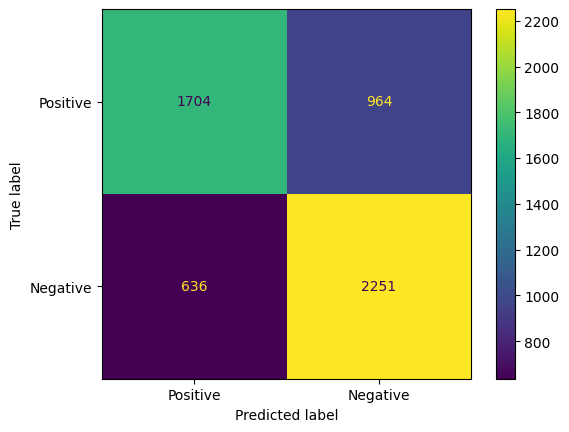

In [100]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

Использую confusion matrix для более детального анализа моделей. Хотя это и не совсем для данной задачи нужно, потому что нам не важно, что важнее уменьшить: FP или FN (как, например, в медицинской диагностике).

FP = 636, FN = 964. Модель больше предсказала проигрышей для сил света, которые на самом деле являются победами.

#### Эксперимент 2

Метод опорных векторов (SVM)

In [14]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [17]:
y_pred = model.predict(X_test)

In [18]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.4990018341233101


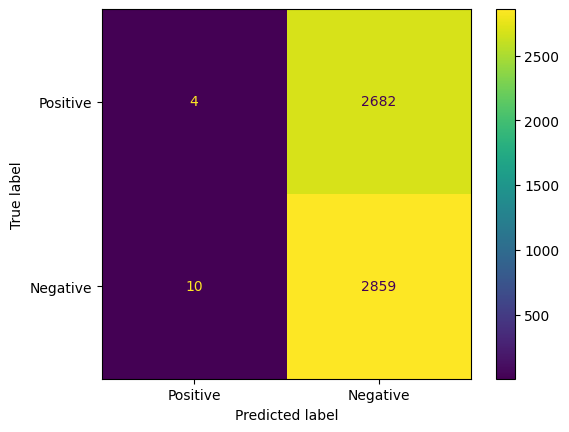

In [19]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

FP = 10, FN = 2682. Модель больше предсказала проигрышей для сил света, которые на самом деле являются победами.

Можно сделать вывод, что линейные модели показывают себя не очень хорошо (svm вообще плохо), т.к. целевая зависимость скорее всего нелинейная (плюс выбросы).

#### Эксперимент 3

Одиночное дерево (Decision Tree)

In [41]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
y_pred = model.predict_proba(X_test)[:, 1]

In [43]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.7718357869198744


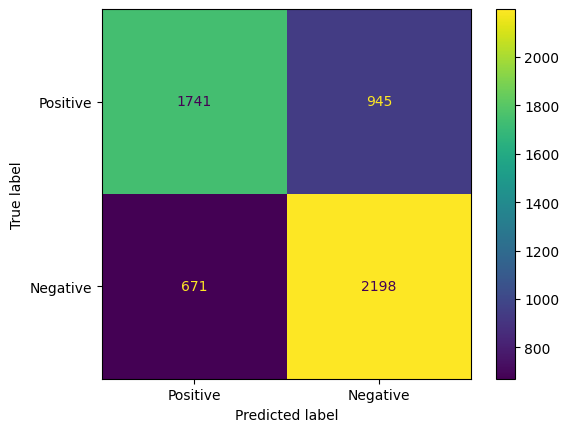

In [44]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

FP = 671, FN = 945. Модель больше предсказала поражений для сил света, которые на самом деле являются победами.

Дерево показало не очень результат на тесте, потому что дерево идеально выучило зависимость на тренировочной выборе и следовательно переобучилось, т.к. дерево не умеет экстраполировать зависимости за границы области значений обучающей выборки.

#### Эксперимент 4

Лес (Random Forest)

In [60]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
y_pred = model.predict_proba(X_test)[:, 1]

In [26]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.8138693150158044


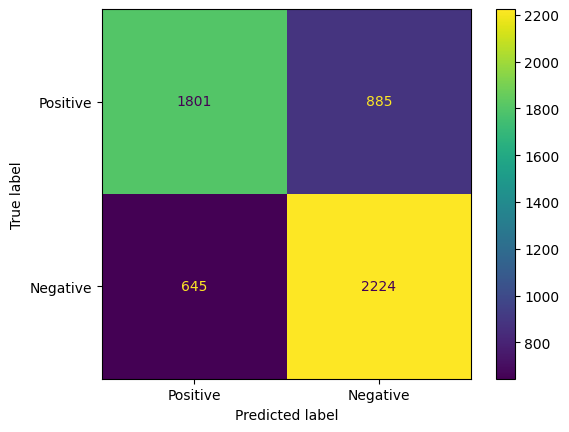

In [27]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

FP = 645, FN = 885. Модель больше предсказала поражений для сил света, которые на самом деле являются победами.

Случайный лес показал себя лучше дерева, потому что за счет случайного выбора подвыборки для каждого дерева леса и случайного выбора признаков в каждой вершине, деревья получаются некоррелируемыми и поэтому уменьшается дисперсия предсказаний у ансамбля относительно входящих в него базовых алгоритмов.

#### Эксперимент 5

Градиентный бустинг

In [87]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [88]:
y_pred = model.predict_proba(X_test)[:, 1]

In [89]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.8208290953674049


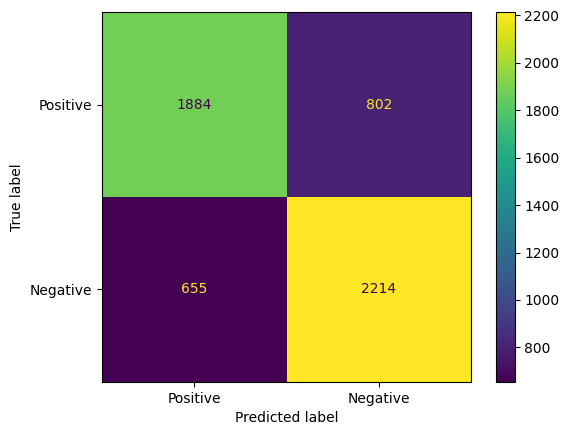

In [90]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

FP = 655, FN = 802. Модель больше предсказала поражений для сил света, которые на самом деле являются победами.

Градиентный бустинг лучше случайного леса отработал, потому что базовые модели строятся последовательно таким образом, что очередной базовый алгоритм решает задачу регрессии с таргетом, равным антиградиенту функции потерь исходной задачи на предсказании ансамбля на предыдущем шаге, то есть очередная базовая модель поправляет ошибки предыдущих.

#### Эксперимент 6 (итоговая модель)

CatBoost

In [67]:
model = CatBoostClassifier(
    random_seed=42,
    logging_level='Silent'
)
model.fit(X_train, y_train)

In [68]:
y_pred = model.predict_proba(X_test)[:, 1]

In [69]:
test_roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC test:", test_roc_auc)

ROC AUC test: 0.8376680187497387


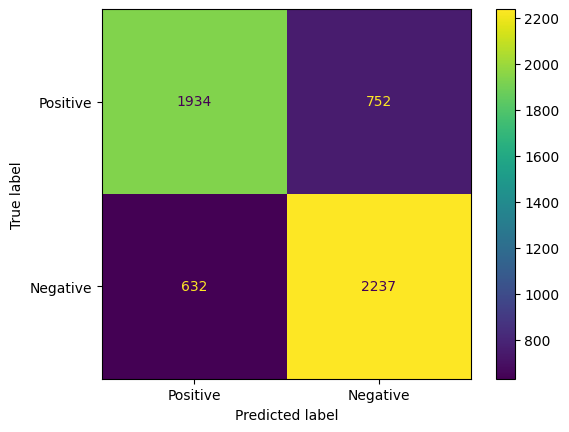

In [123]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)
display_labels = ["Positive", "Negative"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp = disp.plot(values_format='.0f')
plt.show()

FP = 632, FN = 752. Модель больше предсказала поражений для сил света, которые на самом деле являются победами.

Модель на основе градиентного бустинга, которая способна работать с числовыми и категориальными данными. Показала себя лучше остальных моделей.

### Evaluation (оценка качества модели)

ROC AUC test: 0.8376680187497387 для итоговой модели из предыдущего раздела.

In [70]:
predictions = model.predict_proba(df_test)[:, 1]

In [71]:
predictions_df = pd.DataFrame(data={
    'match_id': match_id,
    'radiant_win': predictions})

predictions_df.to_csv('sample_submission.csv', index=False)

### Conclusion (Выводы)

Помогло: ввод новых признаков для сокращения общего количества признаков, с которыми работает модель, построение гистограмм вероятностей для просмотра зависимости между признаком и таргетом с помощью частоты.

Не помогло: фильтрация выбросов и заполнение пропущенных значений в виду особенной итоговой модели.

Получилось: ввести новые признаки, которые улучшили точность модели. Конечный результат: 0.830 на кегле.

Не получилось: поработать с json по техническим причинам. Я пробовала использовать PCA, но график мне показал, что 90% дисперсии можно объяснить 30-50 компонентами и сначала я это не поняла. Но после того как я ввела новые признаки и удалила соответствующие старые, то их действительно стало в разы меньше по количеству. Так же я пробовала использовать стекинг в качестве модели для эксперимента, в котором пробовала объединить логистическую регрессию и дерево/случайный лес. Так же в экспериментах у меня была нейронная сеть (ее нет здесь, потому что я не смогла ее восстановить) с 4 полносвязными слоями. Она дала на удивление плохой результат, потому что нейросети хорошо себя показывают на однородных данных (текст, изображения, аудио, звук).